# **TRABAJO DE FIN DE MASTER - MASTER EN INTELIGENCIA ARTIFICIAL**
**María Soledad Murias Palomer**

El objetivo de este trabajo es crear un modelo que permita predecir la venta futura por tienda de una serie de productos y, a partir de ella, optimizar el inventario de cada tienda dadas ciertas restricciones de espacio y reposición.

En el Notebook 2, se entrenarán modelos de forecast ARIMA y XGBoost con los datos generados en el Notebook 1. El modelo seleccionado será usado en los notebooks siguientes con el fin de poder optimizar el inventario de tiendas.

In [1]:
# Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

!pip install xgboost
import xgboost as xgb


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## PRPARACIÓN DE DATOS



In [3]:
# Importación de datos
file1 = "dataframe.csv" # Archivo con las columnas adicionales de One Hot Encoding
data_stnd = pd.read_csv(file1)

In [4]:
data_stnd.set_index('Fecha', inplace=True)
data_stnd.head()

,Dia Sem,Sem del año,Uns,PrecioUnit,Feriado_FERIADO,Feriado_IRRENUNCIABLE,Feriado_NORMAL,Evento_DIAMADRE,Evento_DIAPADRE,Evento_DIECIOCHO,...,New_Cluster_GUANTE_ZAPATO_ZAPATILLA_ST,New_Cluster_GUANTE_ZAPATO_ZAPATO,New_Cluster_GUANTE_ZAPATO_ZAPATO_CASUAL_CT,New_Cluster_GUANTE_ZAPATO_ZAPATO_CASUAL_ST,New_Cluster_GUANTE_ZAPATO_ZAPATO_ESCOLAR,New_Cluster_GUANTE_ZAPATO_ZAPATO_FORMAL_CT,New_Cluster_GUANTE_ZAPATO_ZAPATO_FORMAL_ST,New_Cluster_GUANTE_ZAPATO_ZAPATO_INFORMAL_CT,New_Cluster_GUANTE_ZAPATO_ZAPATO_INFORMAL_ST,New_Cluster_GUANTE_ZAPATO_ZAPATO_OUTDOOR
Fecha,,,,,,,,,,,,,,,,,,,,,
2023-01-01,7,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01,7,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01,7,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01,7,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01,7,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
data_stnd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68920 entries, 2023-01-01 to 2025-02-20
Columns: 151 entries, Dia Sem to New_Cluster_GUANTE_ZAPATO_ZAPATO_OUTDOOR
dtypes: float64(148), int64(3)
memory usage: 79.9+ MB


## PREDICCIÓN DE VENTA
En esta sección se realizarán el forecast de venta con tres modelos para posterior comparación. Utilizaremos la clasificación de productos entregada por la empresa.

Los modelos a utilizar son: ARIMA y XGBoost



In [6]:
def calc_stat(y_real,y_pred):
  y_mean = y_real.mean()
  ss_total = ((y_real - y_mean) ** 2).sum()
  ss_residual = ((y_real - y_pred) ** 2).sum()
  r2 = 1 - (ss_residual / ss_total)
  rmse = np.sqrt(((y_real - y_pred) ** 2).mean())
  epsilon = 1e-6
  mape = (np.abs((y_real - y_pred) / (y_real+epsilon))).mean() * 100

  return r2, rmse, mape

In [7]:
data_stnd.index = pd.to_datetime(data_stnd.index)

# Haremos un loop que recorra las filas del DataFrame hasta encontrar en el índice el año 2025
indice_primera_fila = 0
for index, row in data_stnd.iterrows():
    if index.year == 2025:
        break
    indice_primera_fila += 1

print(indice_primera_fila)

64481


In [8]:
total_filas = len(data_stnd)
val = indice_primera_fila
train = int(val*0.8)
print(total_filas, train, val)

68920 51584 64481


### ARIMA

In [9]:
data_arima = data_stnd.copy()

atrain = data_arima.iloc[:val]
atest = data_arima.iloc[val:]

X0_train = atrain.drop(columns=['Uns'])
y0_train = atrain['Uns']
X0_test = atest.drop(columns=['Uns'])
y0_test = atest['Uns']

In [10]:
resultado = adfuller(y0_train)
print(f"p-valor: {resultado[1]}")

if resultado[1] > 0.05:  # Si la serie no es estacionaria, aplicamos diferenciación
    y0_train = y0_train.diff().dropna()
    X0_train = X0_train.loc[y0_train.index]  # Asegurar que X tenga el mismo índice que y tras la diferenciación

p-valor: 1.319124075919274e-25


In [ ]:
modelo_auto = auto_arima(
    y0_train, exogenous=X0_train, seasonal=False, trace=True, stepwise=True
)

print(modelo_auto.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=670170.254, Time=61.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=705418.560, Time=1.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=690598.136, Time=1.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=671569.158, Time=15.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=705416.560, Time=0.56 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=670281.108, Time=42.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=670229.207, Time=64.65 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=670199.508, Time=41.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=669811.263, Time=103.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=670128.446, Time=54.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=669851.287, Time=107.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=669836.920, Time=109.91 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=670138.837, Time=44.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=669804.581, Time=117.53 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=669871.148, Time=126.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=669777.122, Time=147.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=670118.370, Time=85.83 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=669801.950, Time=156.61 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,5)(0,0,0)[0]             : AIC=669740.463, Time=90.36 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,5)(0,0,0)[0]             : AIC=670116.400, Time=50.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0]             : AIC=669802.171, Time=62.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,5)(0,0,0)[0]             : AIC=669802.902, Time=83.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0]             : AIC=669838.795, Time=62.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0]             : AIC=669861.273, Time=70.93 sec

Best model:  ARIMA(3,1,5)(0,0,0)[0]          
Total fit time: 1701.490 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                64481
Model:               SARIMAX(3, 1, 5)   Log Likelihood             -334861.231
Date:                Sat, 15 Mar 2025   AIC                         669740.463
Time:                        03:38:47   BIC                         669822.130
Sample:                             0   HQIC                        669765.746
                              - 64481                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2669      0.007     39.843      0.000       

In [ ]:
# Extraer los mejores parámetros obtenidos de auto_arima
p, d, q = modelo_auto.order

In [ ]:
# Ajustar el modelo SARIMAX con regresores exógenos
modelo = ARIMA(y0_train, order=(p, d, q), exog=X0_train)
modelo_arima = modelo.fit()
print(modelo_arima.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    Uns   No. Observations:                64481
Model:                 ARIMA(3, 1, 5)   Log Likelihood             -315674.869
Date:                Sat, 15 Mar 2025   AIC                         631667.738
Time:                        04:05:56   BIC                         633110.522
Sample:                             0   HQIC                        632114.404
                              - 64481                                         
Covariance Type:                  opg                                         
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Dia Sem                                                        1.4363      0.512      2.803      0.005       0.432

In [ ]:
n_periodos = 30  # Predecir 30 días adelante

# Para predecir a futuro, necesitamos valores de los regresores también
X0_forecast = X0_test.iloc[-n_periodos:]  # Tomamos los últimos valores conocidos como estimación
y0_forecast = y0_test.iloc[-n_periodos:]

forecast = modelo_arima.get_forecast(steps=n_periodos, exog=X0_forecast)
predicciones = forecast.predicted_mean
conf_int = forecast.conf_int()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


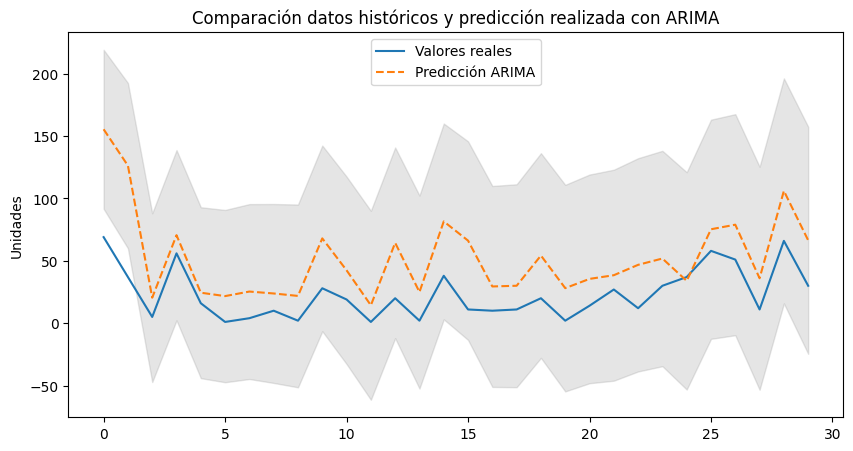

In [ ]:
# Graficar la predicción
plt.figure(figsize=(10, 5))
plt.plot(y0_forecast.reset_index(drop=True), label="Valores reales", color='#1f77b4')
plt.plot(predicciones.reset_index(drop=True), label="Predicción ARIMA", color='#ff7f0e', linestyle="dashed")
plt.fill_between(pd.Series(range(n_periodos)).index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2)
plt.legend()
plt.title('Comparación datos históricos y predicción realizada con ARIMA')
plt.ylabel("Unidades")
plt.show()

In [ ]:
forecast2 = modelo_arima.get_forecast(steps=len(X0_test), exog=X0_test)
predicciones2 = forecast2.predicted_mean

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# Calcular métricas
r2_arima, rmse_arima, mape_arima = calc_stat(y0_test.reset_index(drop=True), predicciones2.reset_index(drop=True))

# Mostrar resultados
print(f"R2: {r2_arima:,.4f}")
print(f"RMSE: {rmse_arima:,.4f}")
print(f"MAPE: {mape_arima:,.4f}")

R2: 0.2997
RMSE: 33.9807
MAPE: 12,848,653.3682


In [ ]:
epsilon = 1e-6

df = pd.DataFrame({
    'y0_test': y0_test.reset_index(drop=True),
    'y0_pred': predicciones2.reset_index(drop=True),
})

df['mape'] = mape = np.abs((df['y0_test'] - df['y0_pred']) / (df['y0_test'] + epsilon)) * 100

# Ordenar el DataFrame por MAPE de forma descendente
df_sorted = df.sort_values(by='mape', ascending=False)
print(df_sorted[:20])

      y0_test    y0_pred          mape
91          0  66.709572  6.670957e+09
2149        0  41.651725  4.165172e+09
135         0  33.101476  3.310148e+09
697         0  29.957704  2.995770e+09
1795        0  29.375054  2.937505e+09
3021        0  28.381902  2.838190e+09
175         0  24.021507  2.402151e+09
2770        0  23.620763  2.362076e+09
1848        0  19.010619  1.901062e+09
146         0  18.917012  1.891701e+09
1191        0  18.614492  1.861449e+09
699         0  16.750758  1.675076e+09
3921        0  16.658626  1.665863e+09
1061        0  16.507484  1.650748e+09
886         0  15.692148  1.569215e+09
1407        0  14.799732  1.479973e+09
189         0  14.625283  1.462528e+09
493         0  14.238793  1.423879e+09
99          0  14.102260  1.410226e+09
3251        0  13.406515  1.340651e+09


In [ ]:
m = 1

# Numerador: Error absoluto del modelo
error_modelo = np.abs(y0_test.reset_index(drop=True) - predicciones2.reset_index(drop=True))

# Denominador: Error absoluto del modelo naive (referencia), usando el valor del periodo anterior
error_referencia = np.abs(predicciones2.reset_index(drop=True).values[m:] - predicciones2.reset_index(drop=True).values[:-m])

# Calcular MASE (Media de los errores absolutos del modelo, escalados por el error de referencia)
mase = error_modelo[m:].sum() / error_referencia.sum()

print(f"MASE: {mase:,.4f}")

# Calcular WAPE (error absoluto ponderado)
error_absoluto = np.abs(y0_test.reset_index(drop=True) - predicciones2.reset_index(drop=True))  # Error absoluto
suma_y_test = np.abs(y0_test.reset_index(drop=True)).sum()  # Suma de los valores reales

# WAPE es el error absoluto total dividido por la suma de los valores reales
wape = (error_absoluto.sum() / suma_y_test) * 100

print(f"WAPE: {wape:,.4f}%")

MASE: 0.9183
WAPE: 92.2636%


In [ ]:
import pickle
with open("arima_model.pkl", "wb") as f:
    pickle.dump(modelo_arima, f)

### XGBoost

In [ ]:
data_xgb = data_stnd.copy()

In [ ]:
dtrain = data_xgb.iloc[:train]
dval = data_xgb.iloc[train:val]
dtest = data_xgb.iloc[val:]

In [ ]:
# Definir variables predictoras y objetivo
X1_train = dtrain.drop(columns=['Uns'])
y1_train = dtrain['Uns']
X1_val = dval.drop(columns=['Uns'])
y1_val = dval['Uns']
X1_test = dtest.drop(columns=['Uns'])
y1_test = dtest['Uns']

In [ ]:
# Crear DMatrix para XGBoost
dmtrain = xgb.DMatrix(X1_train, label=y1_train)
dmval = xgb.DMatrix(X1_val, label=y1_val)
dmtest = xgb.DMatrix(X1_test, label=y1_test)

In [ ]:
# Definir parámetros del modelo
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

In [ ]:
# Entrenar el modelo
model = xgb.train(params, dmtrain, num_boost_round=1000, evals=[(dmval, 'test')], early_stopping_rounds=10)

[0]	test-rmse:52.06616
[1]	test-rmse:51.63461
[2]	test-rmse:51.18113
[3]	test-rmse:50.96233
[4]	test-rmse:50.11069
[5]	test-rmse:49.47219
[6]	test-rmse:48.77757
[7]	test-rmse:48.06357
[8]	test-rmse:47.46443
[9]	test-rmse:46.83466
[10]	test-rmse:46.50103
[11]	test-rmse:45.99346
[12]	test-rmse:45.58245
[13]	test-rmse:45.25152
[14]	test-rmse:44.97298
[15]	test-rmse:44.74419
[16]	test-rmse:44.48147
[17]	test-rmse:44.02961
[18]	test-rmse:43.51404
[19]	test-rmse:43.12358
[20]	test-rmse:42.74342
[21]	test-rmse:42.59266
[22]	test-rmse:42.27642
[23]	test-rmse:41.88013
[24]	test-rmse:41.55224
[25]	test-rmse:41.23975
[26]	test-rmse:40.94103
[27]	test-rmse:40.66307
[28]	test-rmse:40.41083
[29]	test-rmse:40.07295
[30]	test-rmse:39.84774
[31]	test-rmse:39.69322
[32]	test-rmse:39.59457
[33]	test-rmse:39.32626
[34]	test-rmse:39.17494
[35]	test-rmse:39.00381
[36]	test-rmse:38.78071
[37]	test-rmse:38.59208
[38]	test-rmse:38.35615
[39]	test-rmse:38.15962
[40]	test-rmse:38.05308
[41]	test-rmse:37.91871
[4

In [ ]:
# Predicción
y1_pred = model.predict(dmtest)

r2_xgb, rmse_xgb, mape_xgb = calc_stat(y1_test, y1_pred)

# Mostrar resultados
print(f"R2: {r2_xgb:,.4f}")
print(f"RMSE: {rmse_xgb:,.4f}")
print(f"MAPE: {mape_xgb:,.4f}")

R2: 0.7919
RMSE: 18.5244
MAPE: 4,284,138.9773


In [ ]:
epsilon = 1e-6

df = pd.DataFrame({
    'y1_test': y1_test,
    'y1_pred': y1_pred,
})

df['mape'] = mape = np.abs((df['y1_test'] - df['y1_pred']) / (df['y1_test'] + epsilon)) * 100

# Ordenar el DataFrame por MAPE de forma descendente
df_sorted = df.sort_values(by='mape', ascending=False)
print(df_sorted[:20])

            y1_test    y1_pred          mape
Fecha                                       
2025-01-03        0  11.124262  1.112426e+09
2025-01-04        0   9.519952  9.519952e+08
2025-01-18        0   8.655972  8.655972e+08
2025-01-10        0   8.487270  8.487270e+08
2025-01-04        0   8.419896  8.419896e+08
2025-02-15        0   8.191298  8.191298e+08
2025-02-08        0   8.191298  8.191298e+08
2025-02-04        0  -7.947913  7.947913e+08
2025-02-02        0  -7.403847  7.403847e+08
2025-01-23        0  -7.271849  7.271849e+08
2025-02-20        0  -7.016812  7.016812e+08
2025-01-03        0   6.676318  6.676318e+08
2025-02-02        0  -6.562340  6.562340e+08
2025-02-05        0  -5.934221  5.934221e+08
2025-01-14        0  -5.871111  5.871111e+08
2025-01-10        0   5.768561  5.768561e+08
2025-02-04        0  -5.201766  5.201766e+08
2025-01-20        0  -5.201766  5.201766e+08
2025-01-22        0  -5.100875  5.100875e+08
2025-01-18        0   5.058840  5.058840e+08


In [ ]:
m = 1

# Numerador: Error absoluto del modelo
error_modelo = np.abs(y1_test - y1_pred)

# Denominador: Error absoluto del modelo naive (referencia), usando el valor del periodo anterior
error_referencia = np.abs(y1_test[m:] - y1_test[:-m])

# Calcular MASE (Media de los errores absolutos del modelo, escalados por el error de referencia)
mase = error_modelo[m:].sum() / error_referencia.sum()

print(f"MASE: {mase:,.4f}")

# Calcular WAPE (error absoluto ponderado)
error_absoluto = np.abs(y1_test - y1_pred)  # Error absoluto
suma_y_test = np.abs(y1_test).sum()  # Suma de los valores reales

# WAPE es el error absoluto total dividido por la suma de los valores reales
wape = (error_absoluto.sum() / suma_y_test) * 100

print(f"WAPE: {wape:,.4f}%")

MASE: 0.0039
WAPE: 40.7277%


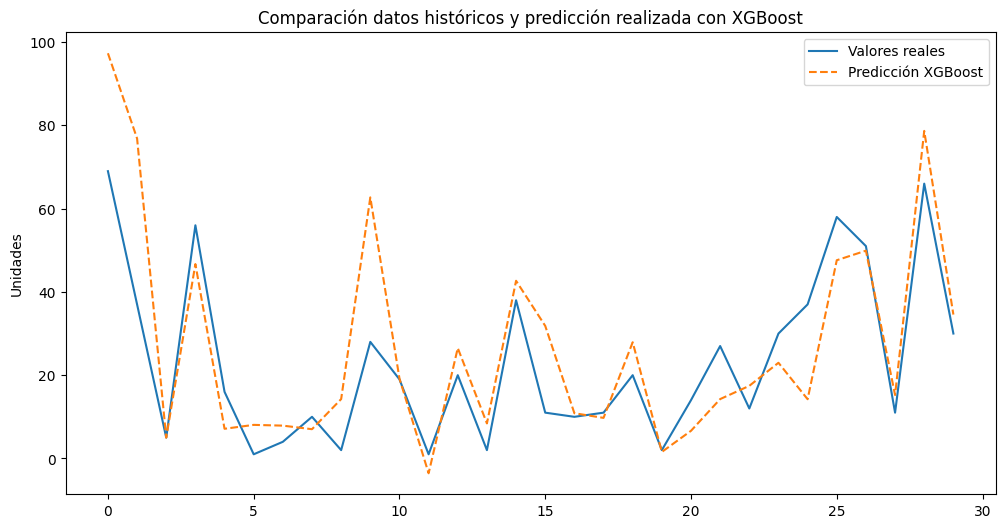

In [ ]:
# Graficar predicción y datos reales
plt.figure(figsize=(12, 6))
plt.plot(y1_test[-30:].values, label='Valores reales', color='#1f77b4')
plt.plot(y1_pred[-30:], label='Predicción XGBoost', color='#ff7f0e', linestyle='dashed')
plt.title('Comparación datos históricos y predicción realizada con XGBoost')
plt.ylabel('Unidades')
plt.legend()
plt.show()

In [ ]:
model.save_model("xgboost_model.json")